<a href="https://colab.research.google.com/github/Matonice/Advance_NLP/blob/main/Implementing_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
!pip install -U keras

In [26]:
#Read in data, clean it, and then split it into train and test split
import gensim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option("display.max_colwidth", 100)

messages = pd.read_csv('SMSSpamCollection.tsv', sep='\t', header=None)
#messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
messages.columns = ["label", "text"]
labels = np.where(messages["label"] == "spam", 1, 0)

x_train, x_test, y_train, y_test = train_test_split(messages["text"],labels, test_size=0.2)

In [6]:
#import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [7]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [8]:
# Use the tokenizer to transform the text message in the training and test data
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [9]:
# What do these sequences look like?
x_train_seq[0]

[215,
 16,
 2012,
 49,
 432,
 13,
 3801,
 40,
 1260,
 282,
 26,
 1261,
 414,
 155,
 636,
 501,
 598,
 172,
 301,
 395,
 371,
 162,
 3802,
 3803,
 415,
 272,
 2013,
 2599,
 372]

In [11]:
# pad the sequences so each sequence is the same length
x_train_seq_padded = pad_sequences(x_train_seq, 50)
x_test_seq_padded = pad_sequences(x_test_seq, 50)

In [12]:
# What do these padded sequences look like?

x_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  215,
         16, 2012,   49,  432,   13, 3801,   40, 1260,  282,   26, 1261,
        414,  155,  636,  501,  598,  172,  301,  395,  371,  162, 3802,
       3803,  415,  272, 2013, 2599,  372], dtype=int32)

## Build Model

In [27]:
# import the tool needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum((K.round(K.clip(y_pred, 0, 1))))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

In [28]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          255776    
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 265,185
Trainable params: 265,185
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compile the model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics = ["accuracy", precision_m, recall_m])

In [30]:
history = model.fit(x_train_seq_padded, y_train,
                    batch_size=32, epochs=10,
                    validation_data = (x_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 14s 74ms/step - loss: 0.4295 - accuracy: 0.8646 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3861 - val_accuracy: 0.8698 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
140/140 [==============================] - 7s 50ms/step - loss: 0.3865 - accuracy: 0.8651 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3891 - val_accuracy: 0.8698 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/10
140/140 [==============================] - 4s 32ms/step - loss: 0.3142 - accuracy: 0.8657 - precision_m: 0.0929 - recall_m: 0.0251 - val_loss: 0.4566 - val_accuracy: 0.8609 - val_precision_m: 0.2000 - val_recall_m: 0.0537
Epoch 4/10
140/140 [==============================] - 6s 40ms/step - loss: 0.2117 - accuracy: 0.9127 - precision_m: 0.7133 - recall_m: 0.5289 - val_loss: 0.5485 - val_accuracy: 0.8043 - val_precision_m: 0.1512 - val_recall_m: 0.1413
Epoch 5/10
140/140 [===============

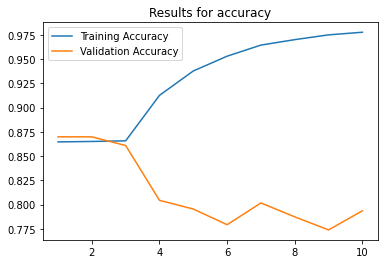

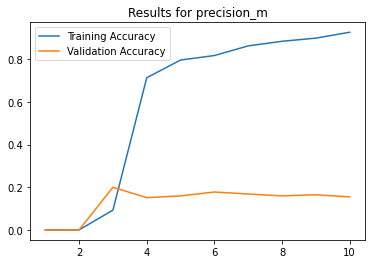

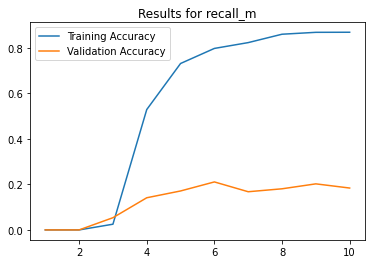

In [34]:
# Plot the evaluation metrics by each epoch for the model to see if we aare over or underfitting 

import matplotlib.pyplot as plt

for i in ["accuracy", "precision_m", "recall_m"]:
  acc = history.history[i]
  val_acc = history.history["val_{}".format(i)]
  epochs = range(1, len(acc) + 1)

  plt.figure()
  plt.plot(epochs, acc, label="Training Accuracy")
  plt.plot(epochs, val_acc, label="Validation Accuracy")
  plt.title("Results for {}".format(i))
  plt.legend()
  plt.show()